# Analysis of co-expression networks generated from NSCLCs

In this notebook we will use RNAseq data from a cohort of NSCLC patients treated with anti-PD1 therapy as part of the cohort published in this [paper](https://www.nature.com/articles/s41467-019-12159-9)

In [1]:
import networkx as nx
import pandas as pd
import os
import sys

In [2]:
f"{'/'.join(os.getcwd().split('/')[0:7])}"

'/Users/cbromley/Documents/Python/vscode/network-biology'

In [3]:
# add path to main repo to sys path
sys.path.insert(0, f"{'/'.join(os.getcwd().split('/')[0:7])}")

In [4]:
# now import network functions
from src.networks import *

In [5]:
# constants
expr_path = "/Users/cbromley/Dropbox (The University of Manchester)/CII share folder (1)/Chris data/Agrin/human_icb/Jung_nsclc_log2tpmplus1.txt"
clin_path = "/Users/cbromley/Dropbox (The University of Manchester)/CII share folder (1)/Chris data/Agrin/human_icb/Jung_nsclc_clinical.txt"

## Data preparation and exploration

In [6]:
expr = pd.read_csv(expr_path, sep=' ')
clin = pd.read_csv(clin_path, sep=' ')

In [7]:
expr.shape

(25633, 27)

Here we have >25,000 features (Genes) and 27 samples so not a huge dataset in terms of the number of samples.

Let's take a look at variance in expression:

<AxesSubplot: >

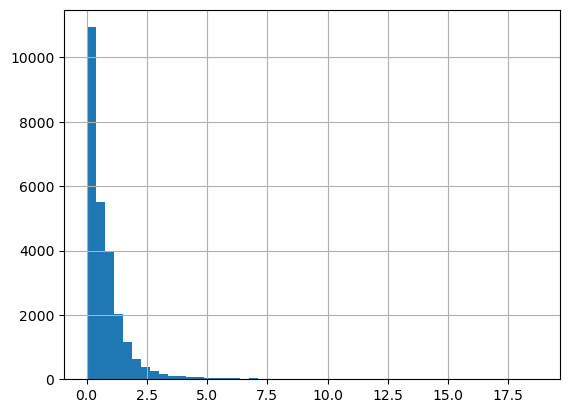

In [8]:
expr.T.var(axis=0).hist(bins=50)

Select 5000 most variable genes and subset expression dataset.

In [9]:
top5000 = expr.var(axis=1).sort_values(ascending=False)[0:5000].index

In [10]:
var_filt = expr.loc[top5000,].T

RHOU


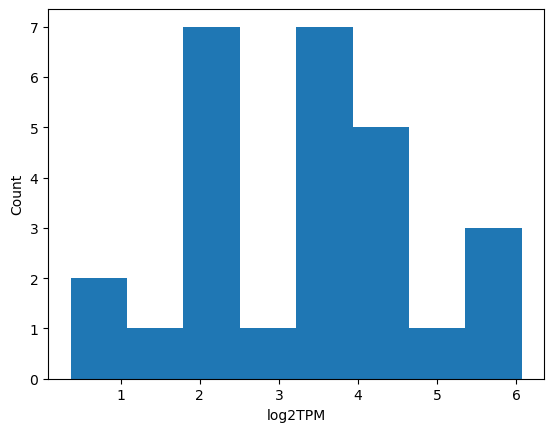

PYCR1


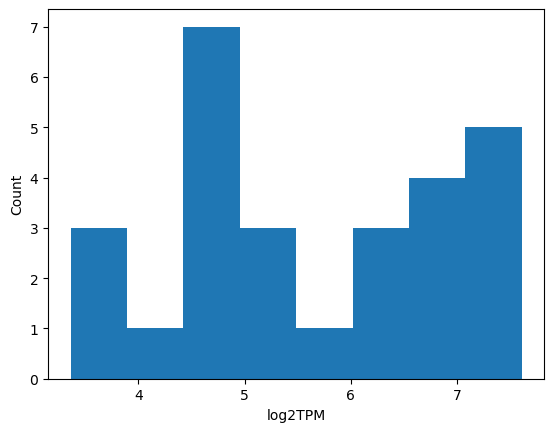

C10orf95


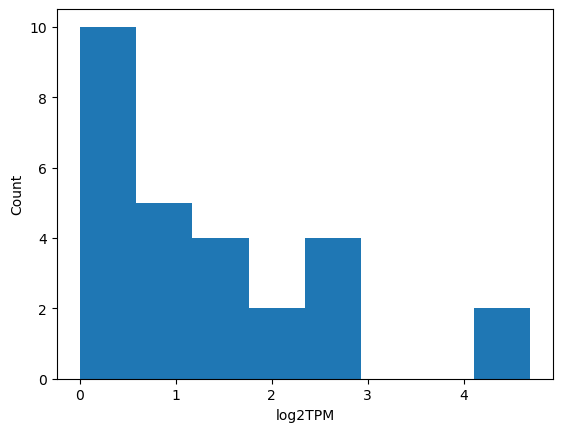

MARVELD1


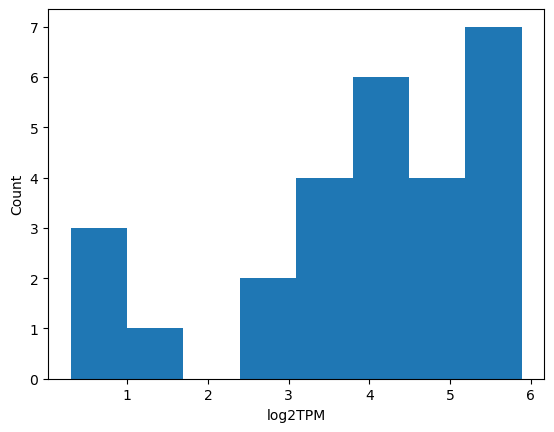

RNF212


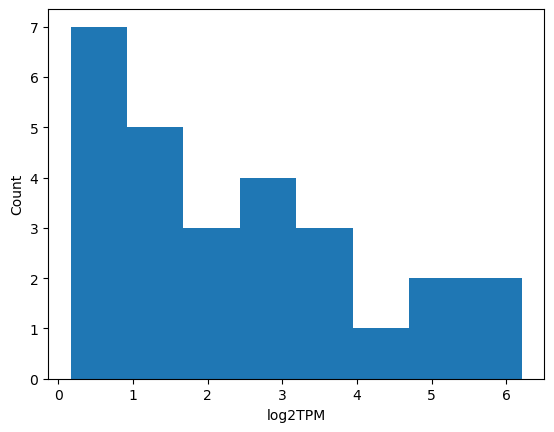

In [11]:
# plot expression distribution of some random genes

# Select 10 random features
random_features = var_filt.sample(n=5, axis=1, random_state=42)

for ind, row in random_features.T.iterrows():
    print(ind)
    plt.hist(row, bins=8)
    plt.xlabel('log2TPM')
    plt.ylabel('Count')
    plt.show()

In [12]:
# take a quick look at clinical data we have for these
clin.head()

,ID,Sample,Response,Status,Sex,Age,censPFS,PFS.x,Tissue,Mutation.burden,Global.methylation.level,Aneuploidy.level,PFS.y,PD_Event.1_Censoring.0,Clinical.benefit
1,NSCLC1017,GSM3995428,NDB,advanced non-small cell lung carcinoma (NSCLC)...,male,38,progression-free survival (pfs): 1,38,tumor tissue,82,0.417538,2.866784e+08,1.266667,1,NDB
2,NSCLC1066,GSM3995427,NDB,advanced non-small cell lung carcinoma (NSCLC)...,female,70,progression-free survival (pfs): 1,23,tumor tissue,42,0.395930,4.897986e+07,0.766667,1,NDB
3,NSCLC1079,GSM3995426,NDB,advanced non-small cell lung carcinoma (NSCLC)...,female,62,progression-free survival (pfs): 1,174,tumor tissue,101,0.392672,1.281598e+08,5.800000,1,NDB
4,NSCLC1104,GSM3995425,NDB,advanced non-small cell lung carcinoma (NSCLC)...,male,73,progression-free survival (pfs): 1,29,tumor tissue,1100,0.293149,8.958192e+08,0.966667,1,NDB
5,NSCLC1145,GSM3995424,NDB,advanced non-small cell lung carcinoma (NSCLC)...,male,60,progression-free survival (pfs): 1,73,tumor tissue,178,0.421131,5.860926e+06,2.433333,1,NDB


It is a little untidy but we clearly have some clinical outcome data here like PFS and response as well as age, sex and some other features from analysis of other genomic data types like global methylation, mutation burden etc.

## Network construction

Now let's put our code to the test. Let's construct some weighted coexp networks. Here we want to incorporate directionality for sure. For now we will not apply a power.

Let's subset to only some genes of interest. We're interested in IFN signalling and MHC class I genes. We will take these and we will also take a random subset of genes. 

In [28]:
custom_genes = [
    "IFNAR1",   # Interferon alpha and beta receptor 1
    "IFNAR2",   # Interferon alpha and beta receptor 2
    "IFNGR1",   # Interferon gamma receptor 1
    "IFNGR2",    # Interferon gamma receptor 2
    "HLA-A",    # MHC class I antigen A
    "HLA-B",    # MHC class I antigen B
    "HLA-C",    # MHC class I antigen C
    "HLA-E",    # MHC class I antigen E
    "HLA-F",    # MHC class I antigen F
    "HLA-G"     # MHC class I antigen G
]


In [29]:
expr_subset = pd.concat([var_filt.sample(n=50, axis=1, random_state=111), 
           expr.loc[custom_genes].T], axis=1)

In [30]:
# generate network 1 - directionalioty
net1 = weighted_coexpression_network(expr_subset, directionality=True, directionality_method="positive_only", power=1, cutoff=0.5)

print(f"Number of nodes in network 1: {len(net1.nodes)}")
print(f"Number of edges in network 1: {len(net1.edges)}")

# generate network 2 - no directionality
net2 = weighted_coexpression_network(expr_subset, directionality=True, directionality_method="positive_norm", power=1, cutoff=0.5)

print(f"Number of nodes in network 2: {len(net2.nodes)}")
print(f"Number of edges in network 2: {len(net2.edges)}")

# generate network 3 - no directionality
net3 = weighted_coexpression_network(expr_subset, directionality=True, directionality_method="positive_negative", power=1, cutoff=0.5)

print(f"Number of nodes in network 3: {len(net3.nodes)}")
print(f"Number of edges in network 3: {len(net3.edges)}")

Number of nodes in network 1: 52
Number of edges in network 1: 119
Number of nodes in network 2: 60
Number of edges in network 2: 1770
Number of nodes in network 3: 53
Number of edges in network 3: 146


In [62]:
networks = {
    'net1': net1,
    'net2': net2,
    'net3': net3
}

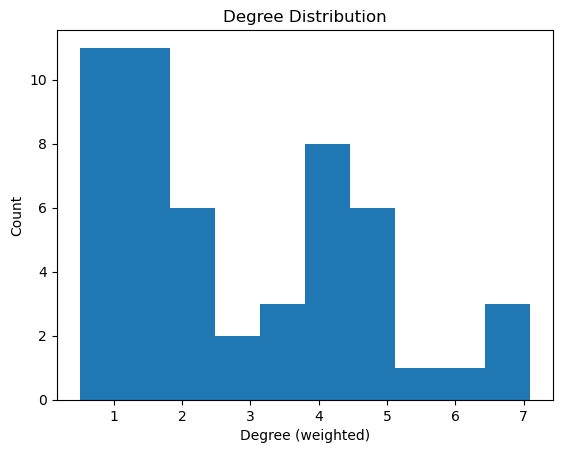

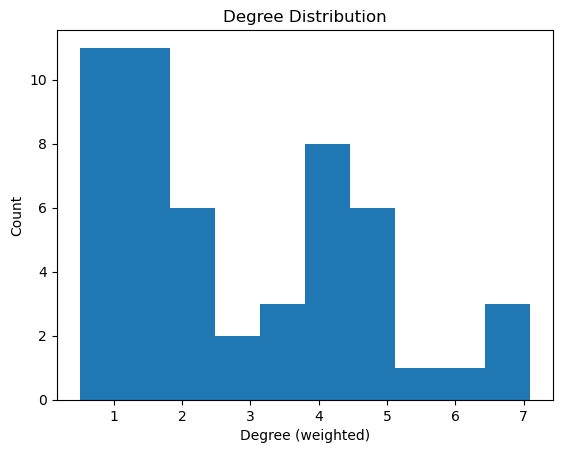

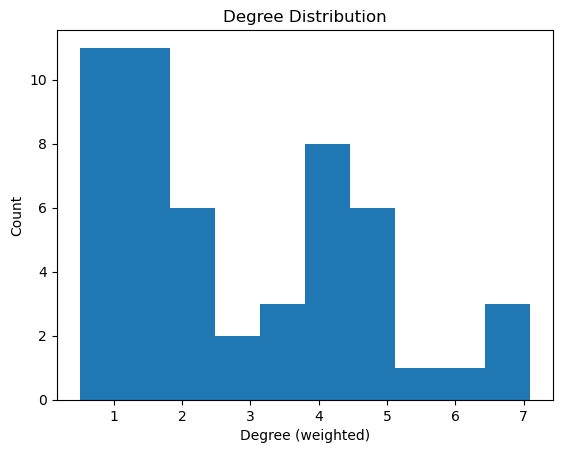

In [63]:
degrees = {}
for key, val in networks.items():
    degrees[key] = plot_degree_distribution(net1)

In [64]:
degrees['net1'].sort_values('weighted_degree', ascending=False).head()

,node,weighted_degree
38,ARF6,7.101458
13,SH2D3A,6.919023
50,HLA-E,6.507741
0,ADI1,5.949311
47,HLA-A,5.235994


Now let's look at the edges between nodes of interest

net1


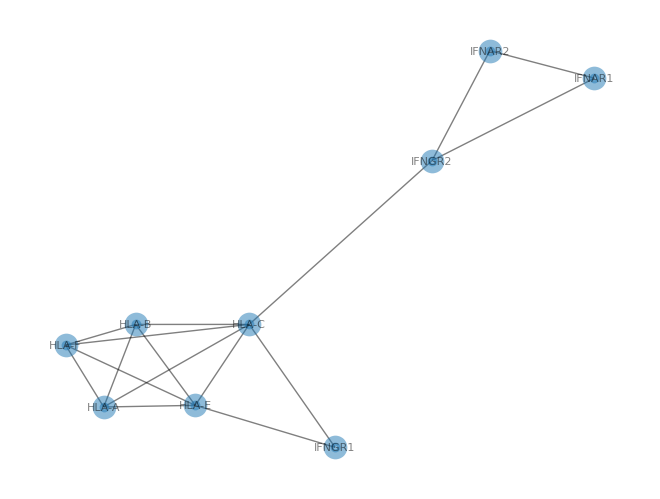

net2


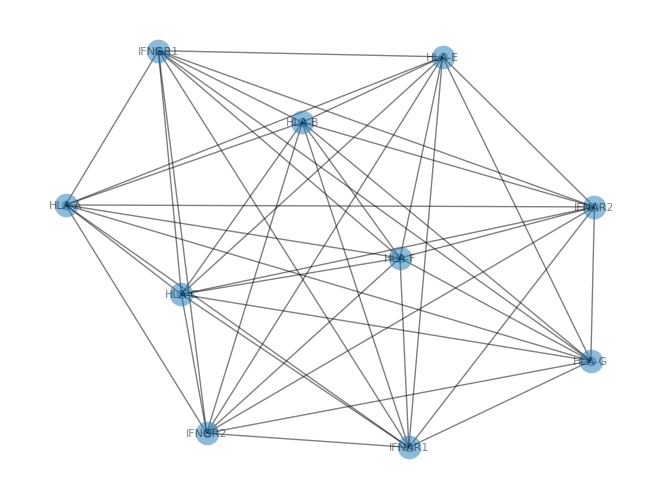

net3


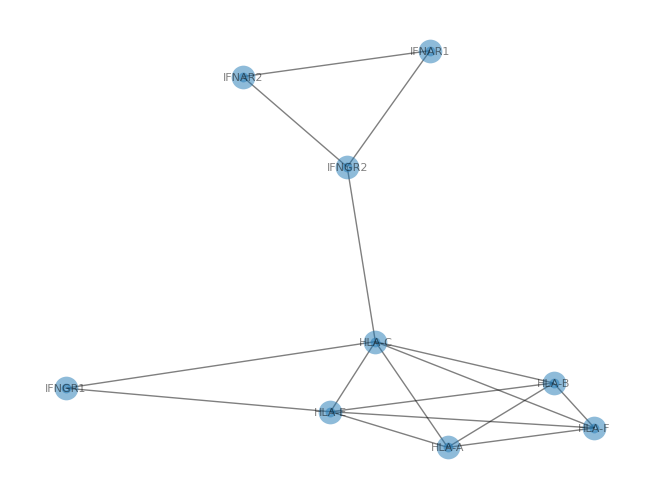

In [65]:
for key, val in networks.items():
    print(key)
    
    # get edges between custom genes
    custom_edges = get_edges_between_nodes(node_set=custom_genes, graph=val)

    custom_graph = nx.Graph(custom_edges)
    
    # plot
    nx.draw(custom_graph,pos=nx.spring_layout(custom_graph), with_labels=True, font_size=8, node_size=50, alpha=0.5, linewidths=10)
    plt.show()